In [1]:
# Import Dependencies
import pandas as pd
import csv
import sys, json
import psycopg2
from sqlalchemy import create_engine
import pymongo
import datetime
import numpy as np
np.random.seed(1)
import requests
from pprint import pprint
import matplotlib.pyplot as plt
from flask import jsonify
import company_domain
company_domain=company_domain.company_domain

# Extraction

### The path to CSV files to extract all Inc 5000 company list

In [52]:
# The path to our CSV files to extract all Inc 5000 company list

# 2019 Inc 5000 company list
Inc_2019_csv = "Resources/inc5000-2019.csv"
# 2018 Inc 5000 company list
Inc_2018_csv = "Resources/inc5000-2018.csv"
# 2007-2017 Inc 5000 company list
Inc_10year_csv ="Resources/inc5000_all10years.csv"


### Read the files

In [53]:
# Read csv file
# Read 2019 Inc 5000 company list
Inc_2019_df = pd.read_csv(Inc_2019_csv)

# Read 2018 Inc 5000 company list
Inc_2018_df = pd.read_csv(Inc_2018_csv)


# Read 2007-2017 Inc 5000 company list
Inc_10year_df = pd.read_csv(Inc_10year_csv,encoding='cp1252')

### Scraping Financial Times Americas Fastest Growing Companies 2020

In [54]:
# Financial times url to scrape
ft_url = 'https://www.ft.com/americas-fastest-growing-companies-2020'

In [55]:
# read the html file for scarping tables 
ft_tables= pd.read_html(ft_url)

In [56]:
# check it's type
type(ft_tables)

list

In [57]:
# Check how many tables are there 
len(ft_tables)

1

In [58]:
# scrape the the first table 
ft_tables_df = ft_tables[0]


In [60]:
# Transforming scraped data

# Drop column we don't need
drop_ft_columns=ft_tables_df.drop(['Revenue 2018 [in $m]','Founding Year','Revenue 2015 [in $m]','Number of employees 2018'], axis=1)


# Remove unnecessary sign "*" from the first column 

drop_ft_columns['Name'] = drop_ft_columns['Name'].str.replace(r'*', '')

# rename columns 
rename_ft_df=drop_ft_columns.rename(columns={"Rank":"rank","Name":"company_name","FT category":"industry","Absolute growth rate [in %]":"growth_rate","Compound annual growth rate (CAGR) [in %]":"compound_annual_growth_rate","Country":"country"})

# Add the year column 
rename_ft_df['rank_year']= '2020'

rename_ft_df['country']= 'United States'

# drop null values Growth

rename_ft_df=rename_ft_df.dropna(axis=1,how='all')

# remove duplicates and show clean data

clean_ft_df=rename_ft_df.drop_duplicates()
clean_ft_df.head()

,rank,company_name,country,industry,growth_rate,compound_annual_growth_rate,rank_year
0,1,Niantic,United States,Games industry,180306.6,1117.4,2020
1,2,UiPath,United States,Technology,37463.5,621.5,2020
2,3,Publisher First (Freestar),United States,Advertising,36680.1,616.5,2020
3,4,FreightWise,United States,Transport,30547.9,574.2,2020
4,5,Veggie Noodle Co.,United States,Food & Beverage,24074.8,523.0,2020


### API Call for Scraping Growjo top 1000 fastest growing companies in 2020.

In [10]:
# API call from Growjo 10,000 - The Fastest Growing Companies list
# We generated companies information based on domains. For example,
# you could retrieve a company’s name, location, employee, estimated revenue and job openings from their domain name. 


# The base url to request the Api call 
base_url = "https://growjo.com/api?url="

# The information we want to extract 
ranking = []
estimated_revenues = []
company_name = []
city = []
country = []
state = []
employees = []
founded = []
industry = []
total_funding = []

# a list of domains imported as company_domain you can find the list in company_domain.py in the main folder


# A for loop to get each domains and request information 
for domain in company_domain:
    target_url = base_url + domain
    data = requests.get(target_url)
    try:
        response = data.json()
    except ValueError:
        pass
# append all requested information letter to retrive
    ranking.append(response['ranking'])
    estimated_revenues.append(response['estimated_revenues'])
    company_name.append(response['company_name'])
    founded.append(response['founded'])
    city.append(response['city'])
    country.append(response['country'])
    state.append(response['state'])
    employees.append(response['employees'])
    industry.append(response['industry'])
    total_funding.append(response['total_funding'])
    

In [11]:
# Crerate and store the information in dictionary  
growjo_df = pd.DataFrame({
    "rank":ranking,
    "revenue_$":estimated_revenues,
    "company_name": company_name,
    "city":city,
    "founding_year":founded,
    "country":country,
    "state":state,
    "number_of_employees":employees,
    "industry":industry,
    "total_funding":total_funding
})

# Remove duplicate values
growjo_df=growjo_df.drop_duplicates()
#growjo_df.head()

In [61]:
# Transforming Growjo top 1000 fastest growing companies in 2020
# drop null values

growjo_df=growjo_df.dropna(axis=1,how='all')
# Add the year column 
growjo_df['rank_year']= '2020'

# remove duplicates and show clean data

clean_growjo_df=growjo_df.drop_duplicates()
clean_growjo_df.head()

,rank,revenue_$,company_name,city,founding_year,country,state,number_of_employees,industry,total_funding,rank_year
0,1.0,36450000.0,LetsGetChecked,New York,2014.0,United States,NY,135,Hospital/Healthcare,$113M,2020
1,701.0,13120000.0,100 Thieves,Los Angeles,2017.0,United States,CA,64,Entertainment,None,2020
2,832.0,97340000.0,10X Genomics,Pleasanton,2012.0,United States,CA,628,Biotech,$242.6M,2020
3,124.0,29870000.0,15Five,San Francisco,2011.0,United States,CA,206,Tech Services,$42.1M,2020
4,941.0,10793000.0,2ULaundry,Charlotte,2015.0,United States,NC,43,Consumer,None,2020


# Transforming

### Cleaning 2019 Inc 5000 company list

In [99]:
# Drop column we don't need
drop_column_2019=Inc_2019_df.drop(['Profile','_ - previous_workers','_ - founded','_ - metro','url','_ - yrs_on_list'], axis=1)

# Add the year column 
drop_column_2019['rank_year']= '2019'

# Rename columns 
rename_df_2019= drop_column_2019.rename(columns={"_ - rank":"rank","name":"company_name","state":"state","_ - revenue":"revenue_$","_ - growth":"growth_rate","_ - industry":"industry","_ - founded":"founding_year","_ - workers":"number_of_employees","city":"city"})



# re-Order the data to suitable format

cleaned_2019_df =rename_df_2019[['rank','rank_year','company_name','industry','number_of_employees','revenue_$','growth_rate','city','state']]
#cleaned_2019_df.head()

### Cleaning 2018 Inc 5000 company list

In [100]:
# Drop column we don't need

drop_column_2018=Inc_2018_df.drop(['_ - id','_ - zipcode','_ - ifmid','_ - latitude','_ - longitude','_ - website','_ - state_l','_ - metrocode','_ - ifiid','_ - previous_workers','_ - metro','_ - url','_ - partner_lists - partner_lists','_ - yrs_on_list'], axis=1)

# Add the year column 
drop_column_2018['rank_year']= '2018'

# Rename columns 
rename_df_2018=drop_column_2018.rename(columns={"_ - rank":"rank","_ - company":"company_name","_ - state_s":"state","_ - revenue":"revenue_$","_ - founded":"founding_year","_ - growth":"growth_rate","_ - industry":"industry","_ - workers":"number_of_employees","_ - state_l":"state","_ - city":"city"})
rename_df_2018.head()


cleaned_2018_df =rename_df_2018[['rank','rank_year','company_name','industry','number_of_employees','revenue_$','growth_rate','founding_year','city','state']]

cleaned_2018_df.head()


,rank,rank_year,company_name,industry,number_of_employees,revenue_$,growth_rate,founding_year,city,state
0,1.0,2018,SwanLeap,Logistics & Transportation,49.0,98965631.0,75660.8425,2013.0,Madison,WI
1,2.0,2018,PopSockets,Consumer Products & Services,118.0,168837562.0,71423.7620,2010.0,Boulder,CO
2,3.0,2018,Home Chef,Food & Beverage,865.0,255047839.0,60165.5058,2013.0,Chicago,IL
3,4.0,2018,Velocity Global,Business Products & Services,55.0,49175942.0,39816.5093,2013.0,Denver,CO
4,5.0,2018,DEPCOM Power,Energy,104.0,219574136.0,38962.9022,2013.0,Scottsdale,AZ


### Cleaning 10 year (2007-2017) Inc 5000 company list

In [102]:
# Rename columns 

drop_column_10year_df=Inc_10year_df.drop(['_ - state_l','_ - metro','_ - yrs_on_list'],axis=1)

# Add the year column 
rename_10year_df=drop_column_10year_df.rename(columns={"year":"rank_year","_ - rank":"rank","_ - company":"company_name","_ - website":"company_Website","_ - state_s":"state","_ - revenue":"revenue_$","_ - growth":"growth_rate","_ - industry":"industry","_ - workers":"number_of_employees","_ - city":"city"})


cleaned_10year_df =rename_10year_df[['rank','rank_year','company_name','industry','number_of_employees','revenue_$','growth_rate','city','state']]

cleaned_10year_df.head()




,rank,rank_year,company_name,industry,number_of_employees,revenue_$,growth_rate,city,state
0,1,2016,Loot Crate,Consumer Products & Services,218.0,116247698.0,66788.5962,Los Angeles,CA
1,2,2016,Paint Nite,Consumer Products & Services,100.0,55018793.0,36555.2472,Somerville,MA
2,3,2016,CalCom Solar,Energy,47.0,33507450.0,31633.5448,Visalia,CA
3,4,2016,eLuxurySupply.com,Retail,82.0,30695215.0,23619.7198,Evansville,IN
4,5,2016,Company.com,Business Products & Services,48.0,33370967.0,23486.8894,Atlanta,GA


### Combine all Inc 5000 data in to a single dataframe

In [103]:
# combine Inc 5000 data in to a single dataframe
combine_data =[cleaned_2018_df,cleaned_2019_df,cleaned_10year_df]
Inc_5000_df= pd.concat(combine_data)

In [104]:
# Add the year column 
Inc_5000_df['country']= 'United States'
Inc_5000_df.head()

,rank,rank_year,company_name,industry,number_of_employees,revenue_$,growth_rate,founding_year,city,state,country
0,1.0,2018,SwanLeap,Logistics & Transportation,49.0,98965631.0,75660.8425,2013.0,Madison,WI,United States
1,2.0,2018,PopSockets,Consumer Products & Services,118.0,168837562.0,71423.7620,2010.0,Boulder,CO,United States
2,3.0,2018,Home Chef,Food & Beverage,865.0,255047839.0,60165.5058,2013.0,Chicago,IL,United States
3,4.0,2018,Velocity Global,Business Products & Services,55.0,49175942.0,39816.5093,2013.0,Denver,CO,United States
4,5.0,2018,DEPCOM Power,Energy,104.0,219574136.0,38962.9022,2013.0,Scottsdale,AZ,United States


In [105]:
# Merge all data in to a single dataframe
merge_all =[Inc_5000_df,clean_growjo_df,clean_ft_df]
merged_df= pd.concat(merge_all)
merged_df.head()

# Add unique id for company name 
id_df=merged_df.groupby(['company_name'], sort=True).ngroup().apply('{:006}'.format)

merged_df['id']=id_df

# Drop a duplicate value if there is any 
merged_df=merged_df.drop_duplicates('id')
merged_df=merged_df.dropna(subset=['company_name','id','revenue_$','rank','rank_year','company_name','industry','number_of_employees','city','state','country'])


merged_df.head()


,rank,rank_year,company_name,industry,number_of_employees,revenue_$,growth_rate,founding_year,city,state,country,total_funding,compound_annual_growth_rate,id
0,1.0,2018,SwanLeap,Logistics & Transportation,49.0,98965631.0,75660.8425,2013.0,Madison,WI,United States,NaN,NaN,020280
1,2.0,2018,PopSockets,Consumer Products & Services,118.0,168837562.0,71423.7620,2010.0,Boulder,CO,United States,NaN,NaN,016290
2,3.0,2018,Home Chef,Food & Beverage,865.0,255047839.0,60165.5058,2013.0,Chicago,IL,United States,NaN,NaN,009834
3,4.0,2018,Velocity Global,Business Products & Services,55.0,49175942.0,39816.5093,2013.0,Denver,CO,United States,NaN,NaN,022717
4,5.0,2018,DEPCOM Power,Energy,104.0,219574136.0,38962.9022,2013.0,Scottsdale,AZ,United States,NaN,NaN,005862


In [106]:
# Ready the tables in the way to load in postgres sql database

# company table 
Company = merged_df[['id','company_name','number_of_employees','industry','city','state','country','founding_year']]
# drop null values from Id 
Company= Company.dropna(subset=['id'])
# drop duplicate id
Company = Company.drop_duplicates('id')
Company.set_index("id",inplace=True)

# Ranks table 
Ranks=merged_df[['id','rank','rank_year']]
Ranks.set_index("id",inplace=True)

# Groth table

Growth=merged_df[['id','growth_rate','total_funding','compound_annual_growth_rate','revenue_$']]
Growth.set_index("id",inplace=True)

# Load

In [107]:
# Create database connection
engine = create_engine('postgresql+psycopg2://postgres:216724401@2@localhost:5432/top-companies_db')
connection = engine.connect()

In [108]:
# confirm tables
engine.table_names()

['company', 'ranks', 'growth']

In [109]:
# Import data in to company table
Company.to_sql(name='company',con=engine, if_exists='append',index=True)

In [110]:
# Import data in to ranks table
Ranks.to_sql(name='ranks',con=engine, if_exists='append',index=True)

In [111]:
# Import Growth in to ranks table
Growth.to_sql(name='growth',con=engine, if_exists='append',index=True)

In [112]:
# pd read sql the selected company file
pd.read_sql_query('select * from company', con=engine).head()

,id,company_name,number_of_employees,industry,city,state,country,founding_year
0,20280,SwanLeap,49.0,Logistics & Transportation,Madison,WI,United States,2013.0
1,16290,PopSockets,118.0,Consumer Products & Services,Boulder,CO,United States,2010.0
2,9834,Home Chef,865.0,Food & Beverage,Chicago,IL,United States,2013.0
3,22717,Velocity Global,55.0,Business Products & Services,Denver,CO,United States,2013.0
4,5862,DEPCOM Power,104.0,Energy,Scottsdale,AZ,United States,2013.0


In [113]:
# pd read sql the selected ranks file
pd.read_sql_query('select * from ranks', con=engine).head()

,id,rank,rank_year
0,20280,1,2018
1,16290,2,2018
2,9834,3,2018
3,22717,4,2018
4,5862,5,2018


In [114]:
# pd read sql the selected growth file
pd.read_sql_query('select * from growth', con=engine).head()

,id,growth_rate,compound_annual_growth_rate,total_funding,revenue_$
0,20280,75660.8425,None,None,98965631.0
1,16290,71423.762,None,None,168837562.0
2,9834,60165.5058,None,None,255047839.0
3,22717,39816.5093,None,None,49175942.0
4,5862,38962.9022,None,None,219574136.0


# Aggregate

In [115]:
# Total number of companies
pd.read_sql_query('SELECT COUNT(company_name) As "Total Companies" FROM Company', con=engine)

,Total Companies
0,24115


In [116]:
# Query Top 10 industries the companies sourced
top_ten_ind=pd.read_sql_query('SELECT industry, COUNT(company_name) As "Companies Count" FROM Company GROUP BY industry ORDER BY "Companies Count" DESC LIMIT 10', con=engine)
top_ten_ind


,industry,Companies Count
0,Business Products & Services,2430
1,Advertising & Marketing,2199
2,IT Services,1986
3,Health,1714
4,Software,1630
5,Construction,1477
6,Consumer Products & Services,1272
7,Manufacturing,1146
8,Financial Services,1137
9,Government Services,1066


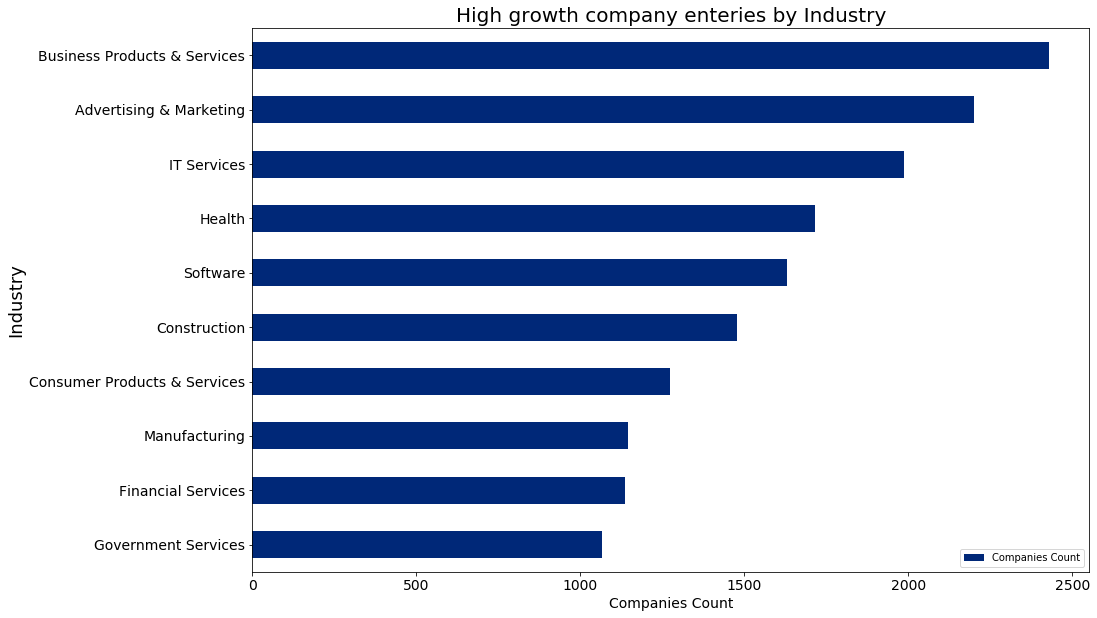

In [117]:
# Industry plot
top_ind_df = top_ten_ind.set_index('industry')
sortedd=top_ind_df.sort_values(by="Companies Count", ascending=True)
plot_pandas =sortedd.plot.barh(figsize=(15,10), color=['#002878'],fontsize = 14)
plt.xlabel("Companies Count",fontsize = 14)
plt.ylabel("Industry",fontsize = 18)
plt.title("High growth company enteries by Industry",fontsize = 20)
plt.savefig("image/industry.png", bbox_inches="tight")
plt.show()

In [118]:
# Query Top 10 state the companies sourced
top_ten_state=pd.read_sql_query('SELECT state, COUNT(company_name) As "Companies Count" FROM Company GROUP BY state ORDER BY "Companies Count" DESC LIMIT 10', con=engine)
top_ten_state


,state,Companies Count
0,CA,3528
1,TX,2001
2,NY,1699
3,FL,1639
4,VA,1258
5,IL,1134
6,GA,971
7,PA,835
8,OH,778
9,NJ,774


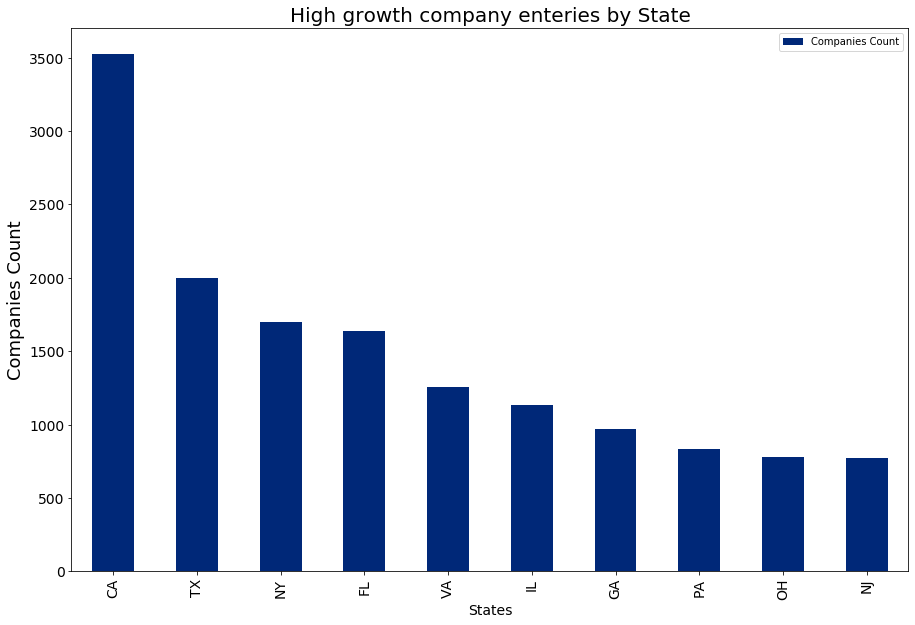

In [119]:
#  state plot
top_ten_state_df = top_ten_state.set_index('state')
plot_pandas =top_ten_state_df.plot.bar(figsize=(15,10), color=['#002878'],fontsize = 14)
plt.xlabel("States",fontsize = 14)
plt.ylabel("Companies Count",fontsize = 18)
plt.title("High growth company enteries by State",fontsize = 20)
plt.savefig("image/state.png", bbox_inches="tight")
plt.show()

In [120]:
# Query Top 10 city the companies sourced
top_ten_city=pd.read_sql_query('SELECT city, COUNT(company_name) As "Companies Count" FROM Company GROUP BY city ORDER BY "Companies Count" DESC LIMIT 10', con=engine)
top_ten_city

,city,Companies Count
0,New York,717
1,Chicago,458
2,Atlanta,404
3,Houston,388
4,Austin,372
5,San Francisco,365
6,San Diego,315
7,Dallas,286
8,Los Angeles,243
9,Denver,218


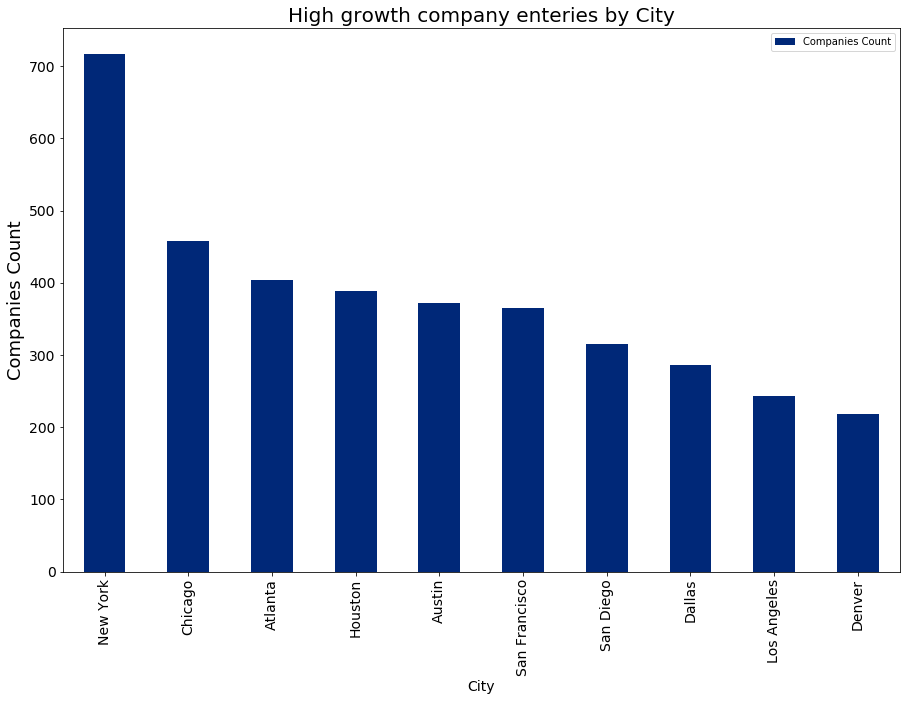

In [121]:
top_ten_city_df = top_ten_city.set_index('city')
plot_pandas =top_ten_city_df.plot.bar(figsize=(15,10), color=['#002878'],fontsize = 14)
plt.xlabel("City",fontsize = 14)
plt.ylabel("Companies Count",fontsize = 18)
plt.title("High growth company enteries by City",fontsize = 20)
plt.savefig("image/city.png", bbox_inches="tight")
plt.show()